In [144]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [145]:
data = pd.read_csv('inflation_world_historic.csv')

In [146]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            70 non-null     float64
 5   1961            72 non-null     float64
 6   1962            74 non-null     float64
 7   1963            74 non-null     float64
 8   1964            79 non-null     float64
 9   1965            86 non-null     float64
 10  1966            93 non-null     float64
 11  1967            100 non-null    float64
 12  1968            101 non-null    float64
 13  1969            102 non-null    float64
 14  1970            107 non-null    float64
 15  1971            111 non-null    float64
 16  1972            114 non-null    float64
 17  1973            117 non-null    flo

Reshaping the dataset 

In [147]:
# Melt the dataset to reshape it into a long format
melted_dataset = data.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year",
    value_name="Inflation"
)

# Remove rows where "Inflation" or "Year" are NaN or invalid
melted_dataset = melted_dataset.dropna(subset=["Inflation"]).reset_index(drop=True)

# Convert the "Year" column to a numeric type, filtering invalid rows
melted_dataset["Year"] = pd.to_numeric(melted_dataset["Year"], errors="coerce")
melted_dataset = melted_dataset.dropna(subset=["Year"]).reset_index(drop=True)

melted_dataset.head(), melted_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10788 entries, 0 to 10787
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    10788 non-null  object 
 1   Country Code    10788 non-null  object 
 2   Indicator Name  10788 non-null  object 
 3   Indicator Code  10788 non-null  object 
 4   Year            10788 non-null  int64  
 5   Inflation       10788 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 505.8+ KB


(   Country Name Country Code                         Indicator Name  \
 0     Australia          AUS  Inflation, consumer prices (annual %)   
 1       Austria          AUT  Inflation, consumer prices (annual %)   
 2       Belgium          BEL  Inflation, consumer prices (annual %)   
 3  Burkina Faso          BFA  Inflation, consumer prices (annual %)   
 4       Bolivia          BOL  Inflation, consumer prices (annual %)   
 
    Indicator Code  Year  Inflation  
 0  FP.CPI.TOTL.ZG  1960   3.728814  
 1  FP.CPI.TOTL.ZG  1960   1.945749  
 2  FP.CPI.TOTL.ZG  1960   0.299467  
 3  FP.CPI.TOTL.ZG  1960   7.788162  
 4  FP.CPI.TOTL.ZG  1960  11.533153  ,
 None)

In [148]:
melted_dataset.isnull().sum()
#check for duplicate rows
melted_dataset["Year"].duplicated().sum()

Country Name      0
Country Code      0
Indicator Name    0
Indicator Code    0
Year              0
Inflation         0
dtype: int64

In [149]:

# Verify the changes
melted_dataset.info(), melted_dataset.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10788 entries, 0 to 10787
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    10788 non-null  object 
 1   Country Code    10788 non-null  object 
 2   Indicator Name  10788 non-null  object 
 3   Indicator Code  10788 non-null  object 
 4   Year            10788 non-null  int64  
 5   Inflation       10788 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 505.8+ KB


(None,
    Country Name Country Code                         Indicator Name  \
 0     Australia          AUS  Inflation, consumer prices (annual %)   
 1       Austria          AUT  Inflation, consumer prices (annual %)   
 2       Belgium          BEL  Inflation, consumer prices (annual %)   
 3  Burkina Faso          BFA  Inflation, consumer prices (annual %)   
 4       Bolivia          BOL  Inflation, consumer prices (annual %)   
 
    Indicator Code  Year  Inflation  
 0  FP.CPI.TOTL.ZG  1960   3.728814  
 1  FP.CPI.TOTL.ZG  1960   1.945749  
 2  FP.CPI.TOTL.ZG  1960   0.299467  
 3  FP.CPI.TOTL.ZG  1960   7.788162  
 4  FP.CPI.TOTL.ZG  1960  11.533153  )

In [151]:
# Group by the "Year" column and calculate the median inflation for each year
yearly_median_inflation = (
    melted_dataset.groupby("Year")["Inflation"].median().reset_index()
)

# Rename columns 
yearly_median_inflation.columns = ["Year", "Median"]

# Display the first few rows of the resulting DataFrame
print(yearly_median_inflation)
yearly_median_inflation.describe()


    Year    Median
0   1960  1.945749
1   1961  2.102977
2   1962  2.669962
3   1963  2.898982
4   1964  3.328408
..   ...       ...
58  2018  2.597456
59  2019  2.206073
60  2020  2.002412
61  2021  3.653533
62  2022  8.160590

[63 rows x 2 columns]


,Year,Median
count,63.000000,63.000000
mean,1991.000000,6.010103
std,18.330303,3.540397
min,1960.000000,1.557907
25%,1975.500000,3.198293
50%,1991.000000,4.475000
75%,2006.500000,9.002897
max,2022.000000,16.976127


In [140]:
# compute the median value of all numeric columns in data

world_yearly_median = melted_dataset["Inflation"].median()
print(melted_dataset.select_dtypes(include="float64"))
print(world_yearly_median)
world_median_data = pd.DataFrame({melted_dataset['Year']: [world_yearly_median]})

        Inflation
0        3.728814
1        1.945749
2        0.299467
3        7.788162
4       11.533153
...           ...
10783   10.961882
10784   11.580510
10785    7.039727
10786   10.993204
10787  104.705171

[10788 rows x 1 columns]
4.918951924254721


TypeError: unhashable type: 'Series'

In [141]:
world_median_data.reset_index(inplace=True)
world_median_data.info() 
world_median_data.head() 

TypeError: unhashable type: 'Series'

In [142]:
world_median_data.columns = [melted_dataset['Year'],'Median']

ValueError: Length mismatch: Expected axis has 5 elements, new values have 2 elements

In [137]:
world_median_data.info() 
world_median_data.head() 
world_median_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                                                             

TypeError: unhashable type: 'Series'

In [113]:
stats = data.select_dtypes(include="float64").agg(['count', 'mean', 'std', 'min', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75), 'max'])
stats.index = ['count', 'mean', 'std', 'min', '25%', '50% (median)', '75%', 'max']
print(stats)


                   1960       1961        1962        1963        1964  \
count         70.000000  72.000000   74.000000   74.000000   79.000000   
mean           3.554980   3.491289    4.630783    5.846612    6.263870   
std            6.795697   4.508248   15.209955   17.152509   13.749261   
min           -5.030042  -3.900000   -3.846154   -2.694655   -4.535654   
25%            0.871370   1.468978    1.147323    1.790965    1.870349   
50% (median)   1.945749   2.102977    2.669962    2.898982    3.328408   
75%            4.037155   3.601606    4.614353    4.998460    4.822426   
max           39.590444  22.747264  131.397849  145.910781  108.994709   

                    1965         1966        1967        1968        1969  \
count          86.000000    93.000000  100.000000  101.000000  102.000000   
mean            8.192841    17.765764    5.469524    6.309715    4.446334   
std            33.376181   117.536433   14.150802   18.309690    4.140570   
min            -3.878976 

# measures:

In [158]:
percentile_95 = np.percentile(yearly_median_inflation['Median'], 95, method='median_unbiased')

percentile_5 = np.percentile(yearly_median_inflation['Median'], 5, method='median_unbiased')

greater_than_95 = (yearly_median_inflation[['Median']] > percentile_95)

smaller_than_5 = (yearly_median_inflation[['Median']] < percentile_5)

# create column named colors to store the color of each point based on the condition above 

yearly_median_inflation['colors'] = np.where(greater_than_95,'r',np.where(smaller_than_5,'r','b'))

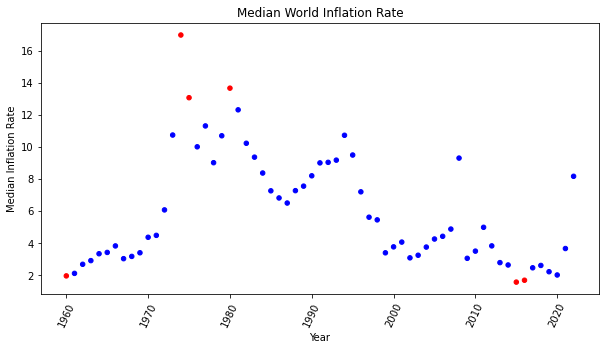

In [159]:
yearly_median_inflation.plot.scatter(x='Year', 

                       y='Median', 

   c=yearly_median_inflation['colors'].apply(lambda x: dict(r='red', b='blue')[x]), 

                       figsize=(10, 5),

                       title='Median World Inflation Rate',

                       xlabel='Year',

                       ylabel='Median Inflation Rate'),

plt.xticks(rotation=65);

# Splitting data : Train data and test data


In [325]:
from sklearn.model_selection import train_test_split

# Assuming 'data' is your dataset and 'target' is the column you're predicting
X = yearly_median_inflation["Year"].values.reshape(-1, 1)   # Features (independent variables)
y = yearly_median_inflation["Median"].values.reshape(-1, 1) # Target (dependent variable)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Print the shapes of the datasets
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)
print(yearly_median_inflation[['Year']].shape)


Training features shape: (50, 1)
Testing features shape: (13, 1)
Training target shape: (50, 1)
Testing target shape: (13, 1)
(63, 1)


In [326]:
LinearRegression_model = LinearRegression()

In [327]:
LinearRegression_model.fit(yearly_median_inflation[['Year']], yearly_median_inflation[['Median']])

LinearRegression()

(13, 1)


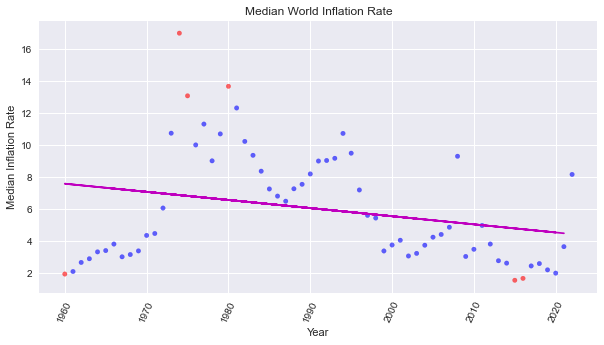

In [331]:

years = X_test  # Convert to NumPy array (2D)

# Generate predictions
reg_prediction = LinearRegression_model.predict(years)
print(reg_prediction.shape)

# Plot scatter plot
ax = yearly_median_inflation.plot.scatter(
    x='Year', 
    y='Median',
    c=yearly_median_inflation['colors'].apply(lambda x: dict(r='red', b='blue')[x]),
    alpha=0.6,
    figsize=(10, 5),
    title='Median World Inflation Rate',
    xlabel='Year',
    ylabel='Median Inflation Rate'
)

# Plot regression line
ax.plot(years, reg_prediction, c='m')

# Rotate x-axis labels 
plt.xticks(rotation=65)
plt.show()


In [332]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate Linear Regression model
mae = mean_absolute_error(y_test, reg_prediction)
mse = mean_squared_error(y_test, reg_prediction)
r2 = r2_score(y_test, reg_prediction)

print(f"Linear Regression - MAE: {mae}, MSE: {mse}, R²: {r2}")

Linear Regression - MAE: 2.5092100689161403, MSE: 8.141595444430966, R²: -0.35822226355739306


# Local Outlier Model


In [279]:
# Initialize the LOF model with tuned parameters
n_neighbors = 10  # Adjust neighbours used to calculate local density
#contamination = 0.05  # Adjust expected proportion of outliers 
contamination = 0.1  # Adjusted higher value for better outlier detection

model_LOF = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)


In [280]:
LOF_predictions = model_LOF.fit_predict(yearly_median_inflation[['Median']])

In [281]:
model_LOF_scores = model_LOF.negative_outlier_factor_

In [282]:
yearly_median_inflation['LOF_anomaly_scores'] = model_LOF_scores

yearly_median_inflation['LOF_anomaly'] = LOF_predictions
print(LOF_predictions)
print(model_LOF_scores)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1 -1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1]
[-1.27516173 -1.19265275 -1.07422394 -1.02769469 -0.96095662 -0.97114829
 -1.07768505 -1.00323352 -0.96546597 -0.96028315 -1.25269968 -1.32318187
 -1.13182274 -1.18727793 -3.42137535 -1.89404934 -1.0217156  -1.36737439
 -0.93885607 -1.16886747 -2.10670773 -1.58569443 -1.06015267 -0.94918946
 -0.98914519 -1.03724593 -1.10541143 -1.18477901 -1.0364106  -1.09433472
 -1.03670917 -0.93885607 -0.94104988 -0.93724523 -1.18144952 -0.97329057
 -1.04235593 -1.38589553 -1.30915159 -0.9593901  -1.02979883 -1.07880083
 -0.9890205  -0.96282845 -1.02264952 -1.15458787 -1.28933061 -1.38926775
 -0.94918946 -0.98643022 -0.99508391 -1.33561474 -1.07912242 -1.05682208
 -1.06499952 -1.53517802 -1.45296232 -1.10155095 -1.09213295 -1.16553628
 -1.24542655 -1.00147933 -1.03594582]


In [283]:
plt.style.use("seaborn")

# false positives

In [284]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)


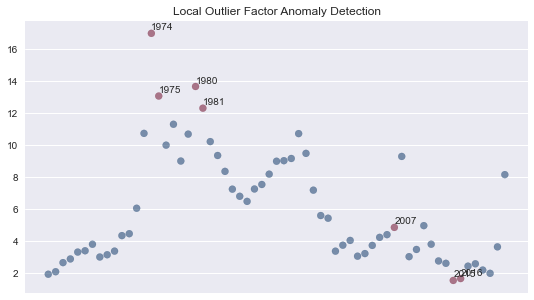

In [285]:
fig, ax = plt.subplots(1, figsize=(9, 5), sharex=True, sharey=False)

ax.scatter(yearly_median_inflation['Year'], 

            yearly_median_inflation['Median'], 

            c=yearly_median_inflation['LOF_anomaly'], 

            cmap='RdBu', 

            alpha=0.5

            )

ax.set_title("Local Outlier Factor Anomaly Detection")

for anomaly in yearly_median_inflation[yearly_median_inflation['LOF_anomaly'] == -1]['Year']:

    ax.annotate(anomaly, 

xy=(anomaly, 

yearly_median_inflation[yearly_median_inflation['Year'] == anomaly]['Median']),

xytext=(anomaly, 

yearly_median_inflation[yearly_median_inflation['Year'] == anomaly]['Median'] + 0.2))

ax.get_xaxis().set_visible(False)

# Metrics


In [286]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [353]:
# LOF Predictions (-1 = outlier, 1 = inlier)
thresholded_predictions = np.where(LOF_predictions == -1, 0, 1)  # Convert to binary (1 for inliers, 0 for outliers)
print(thresholded_predictions)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1]


In [350]:
# Manually labeling actual data using a threshold 
Median = model_LOF_scores
# Set a threshold based on the 90th percentile of LOF scores
threshold = np.percentile(Median, 90)
Median_binary = np.where(Median >= threshold, 0, 1)# Convert to binary (1 for inliers, 0 for outliers)
print(Median_binary)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [351]:

# Calculate confusion matrix
cm = confusion_matrix(Median_binary, thresholded_predictions)
print(cm.shape)

# If it's a 2x2 confusion matrix, unpack the values
if cm.shape == (2, 2):
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
else:
    print("Confusion matrix is not 2x2, please check the inputs.")

(2, 2)
Confusion Matrix: TN=7, FP=0, FN=49, TP=7


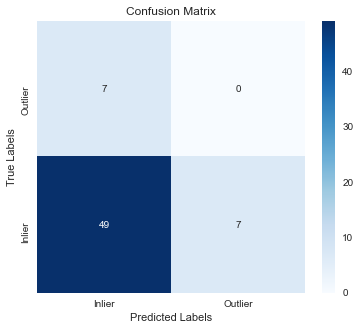

In [360]:
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Inlier', 'Outlier'], yticklabels=['Outlier', 'Inlier'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [333]:
false_positive_rate = fp/(fp+tn)
print(false_positive_rate)

0.875


In [293]:
# Calculate Precision, Recall, F1 Score, and Accuracy
precision = precision_score(Median_binary, thresholded_predictions)
recall = recall_score(Median_binary, thresholded_predictions)
f1 = f1_score(Median_binary, thresholded_predictions)
accuracy = accuracy_score(Median_binary, thresholded_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.125
Recall: 1.0
F1 Score: 0.2222222222222222
Accuracy: 0.2222222222222222
